In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [2]:
save_dir=f"{exps_dir}/exp2/exp_smote"
if os.path.exists(save_dir) == False:
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [3]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['Age',
  'AgeOfPolicyHolder',
  'AgentType',
  'BasePolicy',
  'Fault',
  'MaritalStatus',
  'PoliceReportFiled',
  'PolicyType',
  'VehicleCategory',
  'WitnessPresent'],
 'LDA': ['AccidentArea',
  'AddressChange_Claim',
  'Age',
  'AgeOfPolicyHolder',
  'BasePolicy',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'VehicleCategory'],
 'DTC': ['Age',
  'AgeOfVehicle',
  'BasePolicy',
  'Fault',
  'Make',
  'PastNumberOfClaims',
  'PolicyNumber',
  'RepNumber',
  'week_claimed',
  'week_incident'],
 'RD': ['Age',
  'AgeOfVehicle',
  'BasePolicy',
  'Fault',
  'Make',
  'PolicyNumber',
  'PolicyType',
  'VehicleCategory',
  'week_claimed',
  'week_incident'],
 'LGBM': ['Age',
  'AgeOfPolicyHolder',
  'AgeOfVehicle',
  'Make',
  'Month',
  'PolicyNumber',
  'RepNumber',
  'VehiclePrice',
  'week_claimed',
  'week_incident'],
 'XGB': ['Age',
  'AgeOfPolicyHolder',
  'AgeOfVehicle',
  'BasePolicy',
  'Deductible',
  'Fault',
  'Make',
  'MaritalStatus',
  '

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
xgb_model=joblib.load(f'{save_dir}/xgb_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
lgbm_model=joblib.load(f'{save_dir}/lgbm_model.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/Admin/Data/ads_fraud_detection/exps/exp2/exp_smote/xgb_model.joblib'

In [ ]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0352032938754503, 1: 0.9671122223290701}

In [ ]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)

    labels_reshaped = labels.reshape(-1, 1)

    encoder.fit(labels_reshaped)

    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (20422, 2)


In [ ]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [ ]:
x_test.shape

(5089, 34)

In [ ]:
x_train.shape

(20422, 34)

In [ ]:
y_train.value_counts()

FraudFound_P
1               10707
0                9715
Name: count, dtype: int64

In [ ]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    macro_f1_score = K.mean(f1_scores)

    return macro_f1_score

In [ ]:
print(x_train.shape[1])

34


#### * Xây dựng model:

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



In [ ]:
from tensorflow.keras import regularizers
from tabnet_keras.models import TabNetClassifier

# Định nghĩa tham số regularization
l2_reg = 0.01

learning_rate=0.1
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
tabnet_model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
# model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     kernel_regularizer=l2(0.01), **tabnet_params)
# model.compile(loss = 'categorical_crossentropy', optimizer = )
# model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
# model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))



tabnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.categorical_focal_crossentropy, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy',,f1_score])
early_stopping = EarlyStopping(monitor='loss',
    min_delta=0.00005,
    patience=70,
    verbose=1,
    restore_best_weights=True,
)

# checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5",monitor='loss', verbose = 1, save_best_only=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)


In [ ]:
tabnet_model.build(input_shape=(None, 34))
dummy_input = tf.random.normal((1, 34)) 
tabnet_model(dummy_input)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5028929 , 0.49710712]], dtype=float32)>

In [ ]:
tabnet_model.load_weights('weights/tabnet_focal.h5')

In [ ]:
tabnet_model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  26880     
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 26912 (105.12 KB)
Trainable params: 24592 (96.06 KB)
Non-trainable params: 2320 (9.06 KB)
_________________________________________________________________


In [ ]:

def tabnet_feature(model,input_shape=(34), proba=False):
    input = Input(shape=input_shape)
    feature = tabnet_model.get_layer('tab_net_encoder')(input)
    probability=tabnet_model.get_layer('classifier')(feature)
    if proba:
        output=Concatenate()([feature,probability])
    else:
        output=feature
    model = Model(inputs=input,outputs=[output])
    return model
tabnet_model=tabnet_feature(tabnet_model, proba=True)
# output=feat_model(dummy_input)
# print(output.shape)

#### * Xây dựng Stacked_model:

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tensorflow as tf
from tabnet_keras import TabNetClassifier

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        self.model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid',**self.kwargs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',f1_score])

        self.model.fit(x=X, y=y,
          batch_size=128,
          epochs=5,
          callbacks=[early_stopping, lr_scheduler], class_weight={0:0.5, 1:6.4})
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        return (proba > 0.3).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

    def summary(self):
        return self.model.summary()

In [ ]:
# tabnet.load_weights('weights/tabnet_categorical.h5')


In [ ]:
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}

tabnet = TabNetWrapper(**tabnet_params)


In [ ]:
feature_selection.keys()

dict_keys(['LR', 'LDA', 'DTC', 'RD', 'LGBM', 'XGB', 'KNC', 'GNB', 'NN', 'BG', 'NB', 'SVM'])

In [ ]:
from sklearn.ensemble import StackingClassifier

# def create_keras_model():
#     # Thêm các lớp khác vào đây
#     best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
#     best_model.load_weights('weights.h5')
#     return best_model

# tabnet = KerasClassifier(build_fn=create_keras_model, epochs=10)

rf1_model=RandomForestClassifier(n_estimators=100, random_state=seed)
# bg1_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed)
# svm_model=SVC(kernel='rbf',probability=True, gamma='scale' , random_state=seed)
logi_model=LogisticRegression(random_state=seed)
lda_model=LinearDiscriminantAnalysis()
dt_model=DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=4,random_state=seed)
rf_model=RandomForestClassifier(n_estimators=100, random_state=seed, )
knn_model=KNeighborsClassifier(n_neighbors=100)
gau_model=GaussianNB()
svm_model=SVC(kernel='rbf', gamma='scale', random_state=seed)
mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed)
gb_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
lgbm=LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=seed)  # Mô hình LightGBM
xgb=XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed, use_label_encoder=False, eval_metric='mlogloss')  # Mô hình XGBoost# Lặp qua từng mô hình và vẽ đường cong ROC

# # Huấn luyện các mô hình cơ sở
rf1_model.fit(x_train[feature_selection['RD']], y_train)
logi_model.fit(x_train[feature_selection['LR']], y_train)
lda_model.fit(x_train[feature_selection['LDA']], y_train)
dt_model.fit(x_train[feature_selection['DTC']], y_train)
lgbm.fit(x_train[feature_selection['LGBM']], y_train)
xgb.fit(x_train[feature_selection['XGB']], y_train)
# bg_model.fit(x_train, y_train)
# svm_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf1_model.predict_proba(x_train[feature_selection['RD']])
logi_pred = logi_model.predict_proba(x_train[feature_selection['LR']])
lda_pred = lda_model.predict_proba(x_train[feature_selection['LDA']])
dt_pred = dt_model.predict_proba(x_train[feature_selection['DTC']])
lgbm_pred = lgbm_model.predict_proba(x_train[feature_selection['LGBM']])
xgb_pred = xgb_model.predict_proba(x_train[feature_selection['XGB']])
tabnet_pred=tabnet_model.predict(x_train)



# keras_pred = tabnet.predict(x_test)
stacked_input = np.column_stack((rf_pred,logi_pred,lda_pred,dt_pred,lgbm_pred,xgb_pred, tabnet_pred))

rf_pred = rf1_model.predict_proba(x_test[feature_selection['RD']])
logi_pred = logi_model.predict_proba(x_test[feature_selection['LR']])
lda_pred = lda_model.predict_proba(x_test[feature_selection['LDA']])
dt_pred = dt_model.predict_proba(x_test[feature_selection['DTC']])
lgbm_pred = lgbm_model.predict_proba(x_test[feature_selection['LGBM']])
xgb_pred = xgb_model.predict_proba(x_test[feature_selection['XGB']])
tabnet_pred=tabnet_model.predict(x_test)



# keras_pred = tabnet.predict(x_test)
stacked_input_test = np.column_stack((rf_pred,logi_pred,lda_pred,dt_pred,lgbm_pred,xgb_pred, tabnet_pred))

#history=model.fit(x=x_test,y=y_train,
          #validation_data=(x_test,y_test)class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

# tabnet = KerasClassifier(build_fn=model_output, tabnet_params=tabnet_params,batch_size=64,epochs=10000,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
# tabnet = clone(tabnet)
# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    estimators=[('rf',rf1_model), ('logi',logi_model), ('dt',dt_model), ('lda',lda_model),('xgb',xgb_model)],
    final_estimator=tabnet
)
print(stacked_input.shape)
print(y_test.shape)
# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_train)
# stacked_pred = stacked_model.predict(stacked_input)
# stacked_pred

[LightGBM] [Info] Number of positive: 10707, number of negative: 9715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 20422, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524288 -> initscore=0.097227
[LightGBM] [Info] Start training from score 0.097227
160/160 [==============================] - 0s 1ms/step
(20422, 30)
(5089, 1)
Epoch 1/5
160/160 [==============================] - 6s 4ms/step - loss: 0.6495 - accuracy: 0.8409 - f1_score: 0.8733 - lr: 0.0010
Epoch 2/5
160/160 [==============================] - 1s 4ms/step - loss: 0.0581 - accuracy: 0.9978 - f1_score: 0.9980 - lr: 0.0010
Epoch 3/5
160/160 [==============================] - 1s 4ms/step - loss: 0.0245 - accuracy: 0.9999 - f1_sc

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('logi', LogisticRegression(random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_split=4,
                                                       random_state=42)),
                               ('lda', LinearDiscriminantAnalysis()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              c...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.2, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=7, ...))],
                   final_estimator=TabNetWrapper())

In [ ]:
# scores = cross_val_score(stacked_model, x_train, y_train, cv=10, scoring='accuracy')
# print("Cross-validation accuracy scores:", scores)
# print("Mean accuracy:", scores.mean())

In [ ]:

stacked_pred = stacked_model.predict(stacked_input_test)


160/160 [==============================] - 1s 1ms/step


In [ ]:
# stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
stacked_pred = stacked_model.predict(stacked_input_test)
stacked_pred_labels = (stacked_pred > 0.3).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_labels)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

160/160 [==============================] - 0s 1ms/step
Accuracy of Stacked Model: 0.625073688347416


#### * Kết quả đánh giá mô hình:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




accuracy = accuracy_score(y_test, stacked_pred_labels)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, stacked_pred_labels,labels=[1,0]))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.625073688347416
Classification Report:
              precision    recall  f1-score   support

           1       0.07      0.45      0.13       307
           0       0.95      0.64      0.76      4782

    accuracy                           0.63      5089
   macro avg       0.51      0.54      0.44      5089
weighted avg       0.89      0.63      0.72      5089



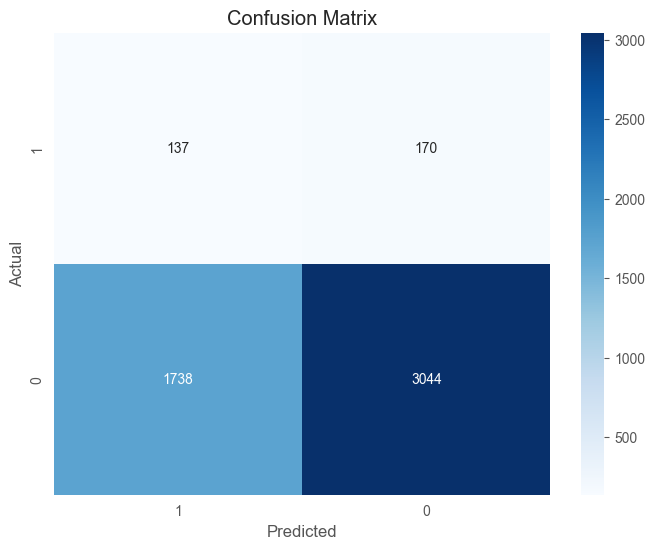

In [ ]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred_labels,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

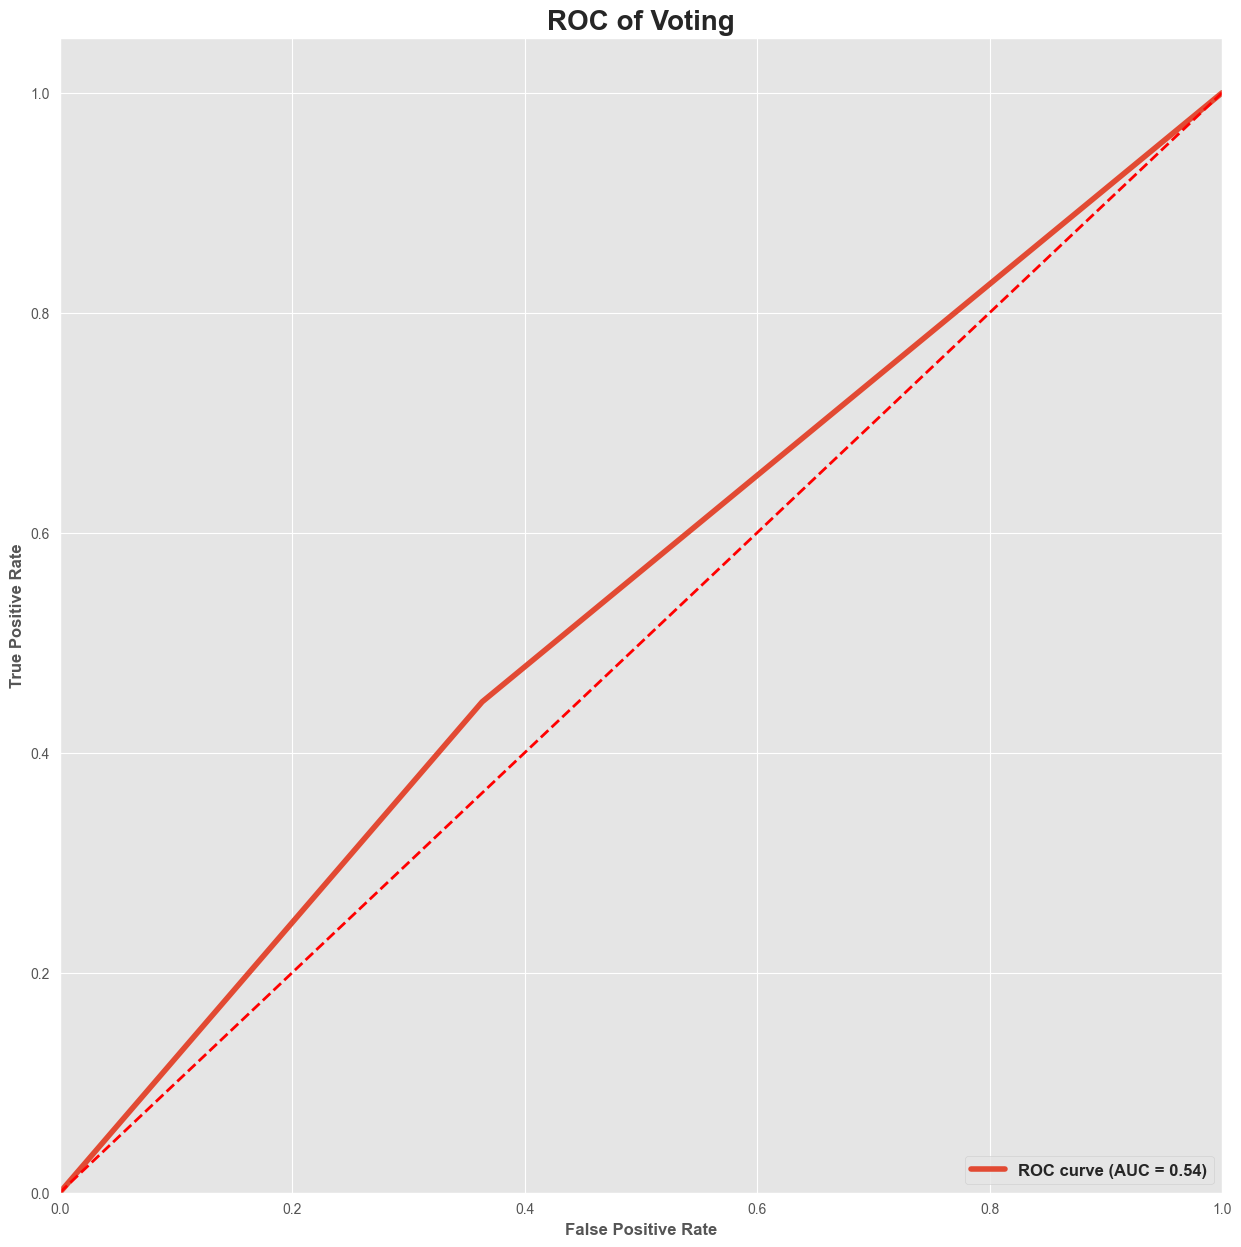

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, stacked_pred)

roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()

In [ ]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [ ]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    stacked_pred_labels = y_predict.argmax(axis=1)

    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(stacked_pred_labels[indx]))
    print("----------------------------")
    if Y_check==check_result(stacked_pred_labels[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1


639/639 [==============================] - 1s 1ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
